In [1]:
import tensorflow as tf
from models import decoder, encoder, vae, classifier
import pandas as pd
import pathlib
from constants import *
from hyperparameters import *
from utils import data_loading
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
apes_info = pd.read_csv(APES_INFO_FILEPATH)
all_images_ids, train_ids, validation_ids, test_ids = data_loading.get_image_ids(apes_info, pathlib.Path(DATA_FILEPATH))

In [3]:
dataset = data_loading.load_full_dataset(DATA_FILEPATH, IMAGE_SIZE, all_images_ids)

y_train, y_validation, y_test, feature_value_names = data_loading.get_feature_dataset_y(apes_info, FEATURE_NAMES)

Found 10000 files belonging to 10000 classes.


In [4]:
x_train = data_loading.load_specific_dataset(dataset, train_ids, None)
train_dataset = tf.data.Dataset.zip((x_train, y_train)).batch(BATCH_SIZE)

x_validation = data_loading.load_specific_dataset(dataset, validation_ids, None)
validation_dataset = tf.data.Dataset.zip((x_validation, y_validation)).batch(BATCH_SIZE)

x_test = data_loading.load_specific_dataset(dataset, test_ids, None)
test_dataset = tf.data.Dataset.zip((x_test, y_test)).batch(BATCH_SIZE)

In [5]:
encoder_model = encoder.build_encoder(**ENCODER_MODEL_HYPERPARAMETERS)
decoder_model = decoder.build_decoder(**DECODER_MODEL_HYPERPARAMETERS)

vae_model = vae.VAE(encoder_model, decoder_model, RECONSTRUCTION_LOSS_WEIGHT, KL_LOSS_WEIGHT)
vae_model.load_weights(MODEL_VAE_FILEPATH)

classifier_model = classifier.build_multilabel_classifier(
    encoder_model=encoder_model,
    **MULTI_LABEL_CLASSIFICATION_MODEL_HYPERPARAMETERS,
    n_unique_features=N_UNIQUE_FEATURES,
    feature_names=FEATURE_NAMES,
)

classifier_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=[tf.keras.losses.BinaryCrossentropy(from_logits=False)] * len(FEATURE_NAMES),
    metrics=["accuracy"],
)

In [9]:
csv_logger = tf.keras.callbacks.CSVLogger(HISTORY_MULTIPLE_LABEL_CLASSIFIER_FILEPATH, append=False)

classifier_model.fit(
    train_dataset.repeat(STEPS_PER_EPOCH * 50),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=50,
    batch_size=None,
    validation_data=validation_dataset,
    callbacks=[csv_logger],
)

classifier_model.save_weights(MODEL_MULTIPLE_LABEL_CLASSIFIER_FILEPATH)

Epoch 1/50


2023-05-30 20:21:08.596814: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype bool and shape [7000,8]
	 [[{{node Placeholder/_14}}]]
2023-05-30 20:21:08.597340: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype bool and shape [7000,37]
	 [[{{node Placeholder/_16}}]]


 7/54 [==>...........................] - ETA: 27s - loss: 2.4876 - Mouth_loss: 0.2995 - Background_loss: 0.3513 - Hat_loss: 0.3139 - Eyes_loss: 0.3758 - Clothes_loss: 0.3053 - Fur_loss: 0.3767 - Earring_loss: 0.4651 - Mouth_accuracy: 0.0915 - Background_accuracy: 0.5234 - Hat_accuracy: 0.0725 - Eyes_accuracy: 0.0759 - Clothes_accuracy: 0.0882 - Fur_accuracy: 0.0971 - Earring_accuracy: 0.5335

KeyboardInterrupt: 

In [6]:
history_classifier_training = pd.read_csv(HISTORY_MULTIPLE_LABEL_CLASSIFIER_FILEPATH)

plt.figure(figsize=(10, len(FEATURE_NAMES) * 3))

for i, feature_name in enumerate(FEATURE_NAMES):
    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 1)
    plt.plot(history_classifier_training[f"{feature_name}_accuracy"])
    plt.plot(history_classifier_training[f"val_{feature_name}_accuracy"])
    plt.title(feature_name)
    plt.ylim([-0.02, 1.02])
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 2)
    plt.plot(history_classifier_training[f"{feature_name}_loss"])
    plt.plot(history_classifier_training[f"val_{feature_name}_loss"])
    plt.title(feature_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/histories/history_multiple_label_classifier_training.csv'

In [6]:
classifier_model.load_weights(MODEL_MULTIPLE_LABEL_CLASSIFIER_FILEPATH)
y_test_predictions = classifier_model.predict(test_dataset)
y_test_true = list(y_test)

2023-05-30 20:25:13.832550: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype bool and shape [1500,19]
	 [[{{node Placeholder/_22}}]]
2023-05-30 20:25:13.832724: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype bool and shape [1500,19]
	 [[{{node Placeholder/_22}}]]


12/12 [==============================] - 16s 1s/step


2023-05-30 20:25:29.634848: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype bool and shape [1500,33]
	 [[{{node Placeholder/_0}}]]


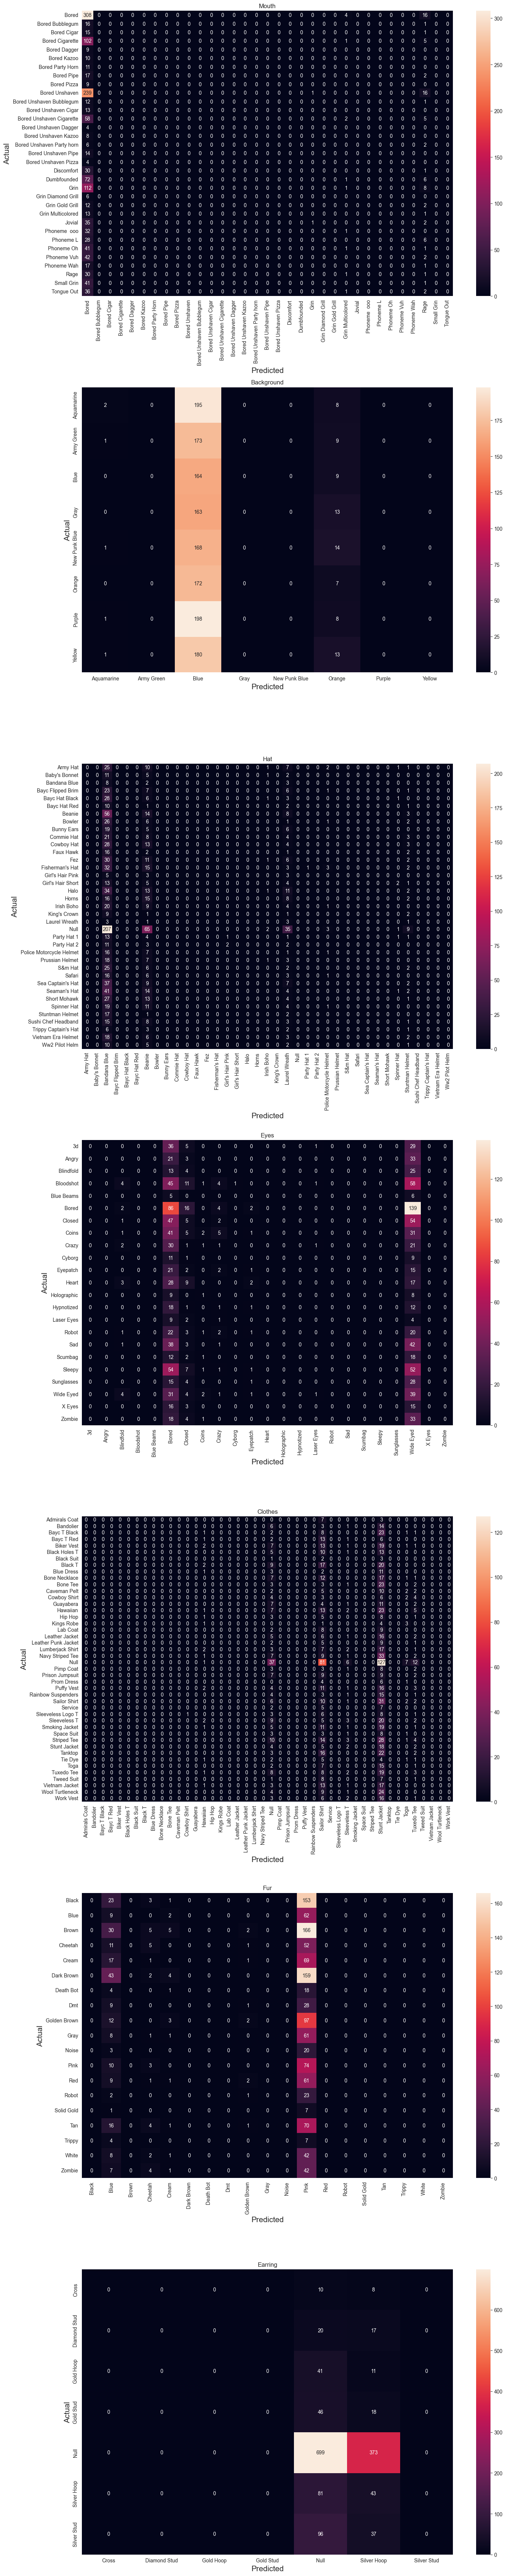

In [29]:
plt.figure(figsize=(15, len(FEATURE_NAMES) * 10))

for i, feature_name in enumerate(FEATURE_NAMES):
    cfm = confusion_matrix(np.argmax([x[i] for x in y_test_true], axis=1), np.argmax(y_test_predictions[i], axis=1))
    df_cfm = pd.DataFrame(cfm, index=feature_value_names[feature_name], columns=feature_value_names[feature_name])

    plt.subplot(len(FEATURE_NAMES), 1, i + 1)
    sns.heatmap(df_cfm, annot=True, fmt=".0f")
    plt.title(feature_name)
    plt.xlabel("Predicted", fontsize=15)
    plt.ylabel("Actual", fontsize=15)

plt.tight_layout()
plt.show()